# Agent Performance Comparison: ReAct vs Chain of Thought
```
=================================================================
This notebook provides comprehensive comparison between:
- ReAct Agent (Reason + Act iteratively)
- Chain of Thought Agent (Plan all → Execute all)

Metrics Measured:
- Execution time
- Number of LLM calls
- Number of tool executions
- Success rate
- Token usage estimation
- Cost estimation
=================================================================
```

In [1]:
# Cell 1: Setup and Imports
"""
Import all necessary dependencies
"""
import os
import sys
import json
import time
import shutil
from pathlib import Path
from typing import List, Dict, Any, Callable
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Rich for beautiful output
from rich import print as rprint
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.progress import Progress, SpinnerColumn, TextColumn, BarColumn, TimeRemainingColumn
from rich.layout import Layout
from rich.live import Live

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

# Load environment
load_dotenv()

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

console = Console()
console.print(Panel.fit(
    "[bold cyan]🔬 Agent Performance Comparison Lab[/bold cyan]\n"
    "[dim]ReAct vs Chain of Thought - Comprehensive Analysis[/dim]",
    style="bold blue"
))

╭────────────────────────────────────────────────────╮
│ 🔬 Agent Performance Comparison Lab                │
│ ReAct vs Chain of Thought - Comprehensive Analysis │
╰────────────────────────────────────────────────────╯

In [2]:
# Cell 2: Configuration
"""
Experiment Configuration
"""

CONFIG = {
    "llm_provider": os.getenv("LLM_PROVIDER", "ollama"),
    "ollama_model": os.getenv("OLLAMA_MODEL", "llama3.1:8b"),
    "sandbox_dir": Path(os.getenv("SANDBOX_DIR", "../sandbox")).resolve(),
    "enable_shell": True,
    "log_level": "INFO",
    
    # Experiment settings
    "test_runs_per_scenario": 1,  # Set to 3-5 for statistical significance
    "react_max_iterations": 20,
    "verbose": False,  # Set to False for cleaner metrics
}

# Create sandbox
CONFIG["sandbox_dir"].mkdir(exist_ok=True)

# Cost estimation (approximate, adjust based on provider)
COST_PER_1K_TOKENS = {
    "ollama": 0.0,  # Free for local
    "openai_gpt4": 0.03,  # Input tokens
    "anthropic_claude": 0.008,
}

rprint("\n[bold cyan]Configuration:[/bold cyan]")
for key, value in CONFIG.items():
    rprint(f"  • {key}: [yellow]{value}[/yellow]")

Configuration:

• llm_provider: ollama  # or openai, anthropic

• ollama_model: llama3.1:8b

• sandbox_dir: /Users/edsonflores/Documents/vsc/Freelance/dev-setup-agent/notebooks/sandbox

• enable_shell: True

• log_level: INFO

• test_runs_per_scenario: 1

• react_max_iterations: 20

• verbose: False

In [3]:
# Cell 3: Import Tool Implementations
"""
Import shared tool implementations
"""

from abc import ABC, abstractmethod
from pydantic import BaseModel, Field
from enum import Enum
from typing import Union
import subprocess
from typing import Set

# Tool Status
class ToolStatus(str, Enum):
    SUCCESS = "success"
    ERROR = "error"
    PARTIAL = "partial"

# Tool Result
class ToolResult(BaseModel):
    """Standardized tool execution result"""
    status: ToolStatus
    output: str
    error: Union[str, None] = None
    metadata: Dict[str, Any] = Field(default_factory=dict)
    
    def __str__(self):
        if self.status == ToolStatus.SUCCESS:
            return f"✅ {self.output}"
        elif self.status == ToolStatus.ERROR:
            return f"❌ Error: {self.error}"
        else:
            return f"⚠️  {self.output}"

# Base Tool
class BaseTool(ABC):
    """Base class for all agent tools"""
    
    @property
    @abstractmethod
    def name(self) -> str:
        pass
    
    @property
    @abstractmethod
    def description(self) -> str:
        pass
    
    @property
    @abstractmethod
    def parameters_schema(self) -> Dict:
        pass
    
    @abstractmethod
    def execute(self, **kwargs) -> ToolResult:
        pass
    
    def to_dict(self) -> Dict:
        return {
            "name": self.name,
            "description": self.description,
            "parameters": self.parameters_schema
        }

rprint("\n[bold green]✓ Tool interfaces loaded[/bold green]")

✓ Tool interfaces loaded

In [4]:
# Cell 4: Tool Implementations (FileSystem, Shell, CodeGenerator)

class FileSystemTool(BaseTool):
    def __init__(self, sandbox_dir: Path):
        self.sandbox_dir = sandbox_dir
    
    @property
    def name(self) -> str:
        return "file_system"
    
    @property
    def description(self) -> str:
        return """Perform file system operations (create, read, write, list files).
        Operations: create, read, write, list, mkdir"""
    
    @property
    def parameters_schema(self) -> Dict:
        return {
            "type": "object",
            "properties": {
                "operation": {"type": "string", "enum": ["create", "read", "write", "list", "mkdir"]},
                "path": {"type": "string"},
                "content": {"type": "string"}
            },
            "required": ["operation", "path"]
        }
    
    def _resolve_path(self, path: str) -> Path:
        full_path = (self.sandbox_dir / path).resolve()
        if not str(full_path).startswith(str(self.sandbox_dir)):
            raise ValueError(f"Path {path} is outside sandbox!")
        return full_path
    
    def execute(self, operation: str, path: str, content: str = None) -> ToolResult:
        try:
            full_path = self._resolve_path(path)
            
            if operation == "create":
                if full_path.exists():
                    return ToolResult(status=ToolStatus.ERROR, output="", error=f"File {path} already exists")
                full_path.parent.mkdir(parents=True, exist_ok=True)
                full_path.write_text(content or "")
                return ToolResult(status=ToolStatus.SUCCESS, output=f"Created file: {path}", 
                                metadata={"path": str(full_path), "size": len(content or "")})
            
            elif operation == "read":
                if not full_path.exists():
                    return ToolResult(status=ToolStatus.ERROR, output="", error=f"File {path} does not exist")
                content = full_path.read_text()
                return ToolResult(status=ToolStatus.SUCCESS, output=content,
                                metadata={"path": str(full_path), "size": len(content)})
            
            elif operation == "write":
                full_path.parent.mkdir(parents=True, exist_ok=True)
                full_path.write_text(content or "")
                return ToolResult(status=ToolStatus.SUCCESS, output=f"Wrote to file: {path}",
                                metadata={"path": str(full_path), "size": len(content or "")})
            
            elif operation == "list":
                if not full_path.exists():
                    return ToolResult(status=ToolStatus.ERROR, output="", error=f"Directory {path} does not exist")
                files = [f.name for f in full_path.iterdir()]
                return ToolResult(status=ToolStatus.SUCCESS, output="\n".join(files),
                                metadata={"count": len(files), "files": files})
            
            elif operation == "mkdir":
                full_path.mkdir(parents=True, exist_ok=True)
                return ToolResult(status=ToolStatus.SUCCESS, output=f"Created directory: {path}",
                                metadata={"path": str(full_path)})
            
            else:
                return ToolResult(status=ToolStatus.ERROR, output="", error=f"Unknown operation: {operation}")
        
        except Exception as e:
            return ToolResult(status=ToolStatus.ERROR, output="", error=str(e))

class ShellTool(BaseTool):
    def __init__(self, sandbox_dir: Path, allowed_commands: Set[str] = None):
        self.sandbox_dir = sandbox_dir
        self.allowed_commands = allowed_commands or {
            'ls', 'cat', 'echo', 'pwd', 'mkdir', 'touch',
            'git', 'python', 'pip', 'npm', 'poetry'
        }
    
    @property
    def name(self) -> str:
        return "shell"
    
    @property
    def description(self) -> str:
        return f"""Execute shell commands. Allowed: {', '.join(sorted(self.allowed_commands))}"""
    
    @property
    def parameters_schema(self) -> Dict:
        return {
            "type": "object",
            "properties": {
                "command": {"type": "string"},
                "working_dir": {"type": "string"}
            },
            "required": ["command"]
        }
    
    def _is_safe_command(self, command: str) -> bool:
        return command.split()[0] in self.allowed_commands
    
    def execute(self, command: str, working_dir: str = ".") -> ToolResult:
        if not self._is_safe_command(command):
            return ToolResult(status=ToolStatus.ERROR, output="", error=f"Command not allowed")
        
        try:
            cwd = self.sandbox_dir / working_dir
            result = subprocess.run(command, shell=True, cwd=cwd, capture_output=True, text=True, timeout=30)
            
            if result.returncode == 0:
                return ToolResult(status=ToolStatus.SUCCESS, 
                                output=result.stdout or "Command executed successfully",
                                metadata={"returncode": result.returncode})
            else:
                return ToolResult(status=ToolStatus.ERROR, output=result.stdout, error=result.stderr,
                                metadata={"returncode": result.returncode})
        except Exception as e:
            return ToolResult(status=ToolStatus.ERROR, output="", error=str(e))

class CodeGeneratorTool(BaseTool):
    TEMPLATES = {
        "fastapi_main": '''"""\nFastAPI Application\n"""\nfrom fastapi import FastAPI\nfrom fastapi.middleware.cors import CORSMiddleware\n\napp = FastAPI(title="{project_name}", description="{description}", version="0.1.0")\n\napp.add_middleware(CORSMiddleware, allow_origins=["*"], allow_credentials=True, allow_methods=["*"], allow_headers=["*"])\n\n@app.get("/")\nasync def root():\n    return {{"message": "Welcome to {project_name}"}}\n\n@app.get("/health")\nasync def health_check():\n    return {{"status": "healthy"}}\n\nif __name__ == "__main__":\n    import uvicorn\n    uvicorn.run(app, host="0.0.0.0", port=8000)\n''',
        "requirements": '''fastapi==0.104.1\nuvicorn[standard]==0.24.0\npydantic==2.5.0\npython-dotenv==1.0.0\npytest==7.4.3\nhttpx==0.25.2\n''',
        "gitignore": '''__pycache__/\n*.py[cod]\n.Python\nvenv/\n.venv/\n.env\n.vscode/\n.idea/\n''',
        "dockerfile": '''FROM python:3.11-slim\nWORKDIR /app\nCOPY requirements.txt .\nRUN pip install -r requirements.txt\nCOPY . .\nCMD ["uvicorn", "main:app", "--host", "0.0.0.0"]\n'''
    }
    
    @property
    def name(self) -> str:
        return "code_generator"
    
    @property
    def description(self) -> str:
        return f"""Generate code from templates. Available: {', '.join(self.TEMPLATES.keys())}"""
    
    @property
    def parameters_schema(self) -> Dict:
        return {
            "type": "object",
            "properties": {
                "template": {"type": "string", "enum": list(self.TEMPLATES.keys())},
                "variables": {"type": "object"}
            },
            "required": ["template"]
        }
    
    def execute(self, template: str, variables: Dict[str, str] = None) -> ToolResult:
        if template not in self.TEMPLATES:
            return ToolResult(status=ToolStatus.ERROR, output="", error=f"Template not found")
        try:
            code = self.TEMPLATES[template]
            if variables:
                code = code.format(**variables)
            return ToolResult(status=ToolStatus.SUCCESS, output=code,
                            metadata={"template": template, "lines": len(code.split('\n'))})
        except Exception as e:
            return ToolResult(status=ToolStatus.ERROR, output="", error=str(e))

rprint("\n[bold green]✓ Tool implementations loaded[/bold green]")

✓ Tool implementations loaded

In [5]:
# Cell 5: LLM Client with Tracking
"""
LLM Client with call tracking for metrics
"""

import httpx

class TrackedOllamaClient:
    """Ollama client with call tracking"""
    
    def __init__(self, base_url: str = "http://localhost:11434", model: str = "llama3.1:8b"):
        self.base_url = base_url
        self.model = model
        self.client = httpx.Client(timeout=90.0)
        
        # Tracking metrics
        self.call_count = 0
        self.total_input_tokens = 0
        self.total_output_tokens = 0
        self.total_time = 0.0
        self.call_history = []
    
    def reset_metrics(self):
        """Reset tracking metrics"""
        self.call_count = 0
        self.total_input_tokens = 0
        self.total_output_tokens = 0
        self.total_time = 0.0
        self.call_history = []
    
    def generate(self, prompt: str, system: str = None) -> str:
        """Generate with tracking"""
        messages = []
        if system:
            messages.append({"role": "system", "content": system})
        messages.append({"role": "user", "content": prompt})
        
        start_time = time.time()
        
        try:
            response = self.client.post(
                f"{self.base_url}/api/chat",
                json={
                    "model": self.model,
                    "messages": messages,
                    "stream": False,
                    "options": {"temperature": 0.1}
                }
            )
            response.raise_for_status()
            result = response.json()
            
            elapsed = time.time() - start_time
            
            # Track metrics
            self.call_count += 1
            self.total_time += elapsed
            
            # Estimate tokens (rough approximation: 1 token ≈ 4 chars)
            input_text = (system or "") + prompt
            output_text = result["message"]["content"]
            
            input_tokens = len(input_text) // 4
            output_tokens = len(output_text) // 4
            
            self.total_input_tokens += input_tokens
            self.total_output_tokens += output_tokens
            
            self.call_history.append({
                "timestamp": datetime.now(),
                "elapsed": elapsed,
                "input_tokens": input_tokens,
                "output_tokens": output_tokens
            })
            
            return output_text
        
        except Exception as e:
            return f"LLM Error: {str(e)}"
    
    def test_connection(self) -> bool:
        try:
            response = self.client.get(f"{self.base_url}/api/tags")
            return response.status_code == 200
        except:
            return False
    
    def get_metrics(self) -> Dict:
        """Get current metrics"""
        return {
            "call_count": self.call_count,
            "total_input_tokens": self.total_input_tokens,
            "total_output_tokens": self.total_output_tokens,
            "total_tokens": self.total_input_tokens + self.total_output_tokens,
            "total_time": self.total_time,
            "avg_time_per_call": self.total_time / self.call_count if self.call_count > 0 else 0
        }

# Initialize
llm = TrackedOllamaClient(model=CONFIG["ollama_model"])

if llm.test_connection():
    rprint("\n[bold green]✓ LLM client ready with tracking[/bold green]")
else:
    rprint("\n[bold red]✗ LLM not available! Start with: ollama serve[/bold red]")

✓ LLM client ready with tracking

In [6]:
# Cell 6: Import ReAct Agent (from agent_testing.ipynb)
"""
ReAct Agent Implementation
"""

import re
from dataclasses import dataclass

@dataclass
class AgentStep:
    iteration: int
    thought: str
    action: str
    action_input: Dict[str, Any]
    observation: ToolResult
    timestamp: datetime

class DevSetupAgent:
    """ReAct Agent"""
    
    def __init__(self, llm: TrackedOllamaClient, tools: List[BaseTool], max_iterations: int = 15, verbose: bool = True):
        self.llm = llm
        self.tools = {tool.name: tool for tool in tools}
        self.max_iterations = max_iterations
        self.verbose = verbose
        self.history: List[AgentStep] = []
        self.context = {}
    
    def _build_system_prompt(self) -> str:
        tools_desc = "\n\n".join([
            f"Tool: {tool.name}\n{tool.description}\nParameters: {json.dumps(tool.parameters_schema, indent=2)}"
            for tool in self.tools.values()
        ])
        
        return f"""You are an autonomous agent. Complete tasks by reasoning step-by-step and using tools ONE AT A TIME.

Available Tools:
{tools_desc}

RULES:
1. ONE action per response
2. Wait for Observation after each action
3. Generated code is saved in context
4. Create directories BEFORE files

Format:
Thought: [reasoning]
Action: [tool_name]
Action Input: {{"param": "value"}}

When done:
Thought: Task complete
Final Answer: [summary]
"""
    
    def _parse_action(self, response: str) -> tuple:
        thought = ""
        action = ""
        action_input = {}
        
        lines = response.strip().split('\n')
        found_action = False
        
        for line in lines:
            line = line.strip()
            if line.startswith("Thought:") and not thought:
                thought = line.replace("Thought:", "").strip()
            elif line.startswith("Action:") and not found_action:
                action = line.replace("Action:", "").strip()
                found_action = True
            elif line.startswith("Action Input:") and found_action:
                input_str = line.replace("Action Input:", "").strip()
                try:
                    action_input = json.loads(input_str)
                except:
                    json_match = re.search(r'\{.*\}', input_str, re.DOTALL)
                    if json_match:
                        try:
                            action_input = json.loads(json_match.group())
                        except:
                            action_input = {"raw": input_str}
                break
        
        return thought, action, action_input
    
    def run(self, task: str) -> str:
        conversation = f"Task: {task}\n\nBegin! ONE action at a time."
        last_generated_content = None
        
        for iteration in range(self.max_iterations):
            response = self.llm.generate(prompt=conversation, system=self._build_system_prompt())
            
            if "Final Answer:" in response:
                return response.split("Final Answer:")[1].strip()
            
            thought, action, action_input = self._parse_action(response)
            
            if not action or action not in self.tools:
                conversation += f"\n\nAssistant: {response}\n\nObservation: Error - Invalid action. Use one of: {list(self.tools.keys())}"
                continue
            
            # Smart placeholder replacement
            if action == "file_system" and "content" in action_input:
                content = action_input["content"]
                placeholders = ["code from", "previous", "generated", "observation"]
                if any(ph in str(content).lower() for ph in placeholders) and len(str(content)) < 100:
                    if last_generated_content:
                        action_input["content"] = last_generated_content
            
            try:
                tool = self.tools[action]
                observation = tool.execute(**action_input)
                
                if action == "code_generator" and observation.status == ToolStatus.SUCCESS:
                    last_generated_content = observation.output
                    self.context[f"gen_{iteration}"] = observation.output
            except Exception as e:
                observation = ToolResult(status=ToolStatus.ERROR, output="", error=str(e))
            
            step = AgentStep(iteration, thought, action, action_input, observation, datetime.now())
            self.history.append(step)
            
            obs_text = observation.output if observation.status == ToolStatus.SUCCESS else f'Error: {observation.error}'
            conversation += f"\n\nAssistant: Thought: {thought}\nAction: {action}\nAction Input: {json.dumps(action_input)}\n\nObservation: {obs_text}"
        
        return "Task not completed within iteration limit"
    
    def get_summary(self) -> Dict:
        return {
            "total_steps": len(self.history),
            "tools_used": list(set(s.action for s in self.history)),
            "success_rate": sum(1 for s in self.history if s.observation.status == ToolStatus.SUCCESS) / len(self.history) if self.history else 0,
        }

rprint("\n[bold green]✓ ReAct Agent loaded[/bold green]")

✓ ReAct Agent loaded

In [7]:
# Cell 7: Import CoT Agent (from cot_agent_testing.ipynb)
"""
Chain of Thought Agent Implementation
"""

@dataclass
class PlannedAction:
    step_number: int
    reasoning: str
    tool: str
    parameters: Dict[str, Any]

@dataclass
class ExecutedStep:
    planned_action: PlannedAction
    result: ToolResult
    timestamp: datetime

class ChainOfThoughtAgent:
    """CoT Agent"""
    
    def __init__(self, llm: TrackedOllamaClient, tools: List[BaseTool], verbose: bool = True):
        self.llm = llm
        self.tools = {tool.name: tool for tool in tools}
        self.verbose = verbose
        self.plan: List[PlannedAction] = []
        self.execution_history: List[ExecutedStep] = []
        self.context = {}
    
    def _build_planning_prompt(self) -> str:
        tools_desc = "\n\n".join([
            f"Tool: {tool.name}\n{tool.description}\nParameters: {json.dumps(tool.parameters_schema, indent=2)}"
            for tool in self.tools.values()
        ])
        
        return f"""You are an agent using Chain of Thought. Create a COMPLETE PLAN upfront.

Available Tools:
{tools_desc}

PLANNING RULES:
1. Think through ENTIRE task
2. Break into sequential steps
3. Each step uses ONE tool
4. After code_generator, immediately write file
5. Use PLACEHOLDER_CODE_FROM_STEP_N to reference generated code

Format:
REASONING:
[Overall approach]

PLAN:

Step 1:
Reasoning: [why]
Tool: [tool_name]
Parameters: {{"param": "value"}}

Step 2:
...
"""
    
    def _parse_plan(self, response: str) -> List[PlannedAction]:
        plan = []
        plan_match = re.search(r'PLAN:\s*(.+)', response, re.DOTALL | re.IGNORECASE)
        if not plan_match:
            return plan
        
        plan_text = plan_match.group(1)
        step_splits = re.split(r'(?=Step\s+\d+:)', plan_text, flags=re.IGNORECASE)
        
        for step_block in step_splits:
            if not step_block.strip():
                continue
            
            step_num_match = re.search(r'Step\s+(\d+):', step_block, re.IGNORECASE)
            if not step_num_match:
                continue
            step_num = int(step_num_match.group(1))
            
            reasoning_match = re.search(r'Reasoning:\s*(.+?)\s*(?=Tool:)', step_block, re.DOTALL | re.IGNORECASE)
            reasoning = reasoning_match.group(1).strip() if reasoning_match else ""
            
            tool_match = re.search(r'Tool:\s*(\S+)', step_block, re.IGNORECASE)
            if not tool_match:
                continue
            tool = tool_match.group(1).strip()
            
            params_match = re.search(r'Parameters:\s*(\{.*)', step_block, re.DOTALL | re.IGNORECASE)
            parameters = {}
            if params_match:
                params_str = params_match.group(1).strip()
                # Extract JSON
                brace_count = 0
                json_end = 0
                in_string = False
                
                for i, char in enumerate(params_str):
                    if char == '"':
                        in_string = not in_string
                    if not in_string:
                        if char == '{':
                            brace_count += 1
                        elif char == '}':
                            brace_count -= 1
                            if brace_count == 0:
                                json_end = i + 1
                                break
                
                json_str = params_str[:json_end] if json_end > 0 else params_str
                try:
                    parameters = json.loads(json_str)
                except:
                    pass
            
            plan.append(PlannedAction(step_num, reasoning, tool, parameters))
        
        return plan
    
    def _execute_plan(self) -> List[ExecutedStep]:
        executed = []
        
        for action in self.plan:
            parameters = action.parameters.copy()
            
            # Replace placeholders
            if "content" in parameters:
                content = str(parameters["content"])
                placeholder_match = re.search(r'PLACEHOLDER_CODE_FROM_STEP_(\d+)', content)
                if placeholder_match:
                    ref_step = int(placeholder_match.group(1))
                    if ref_step in self.context:
                        parameters["content"] = self.context[ref_step]
            
            if action.tool not in self.tools:
                result = ToolResult(status=ToolStatus.ERROR, output="", error=f"Tool not found")
            else:
                try:
                    tool = self.tools[action.tool]
                    result = tool.execute(**parameters)
                    
                    if action.tool == "code_generator" and result.status == ToolStatus.SUCCESS:
                        self.context[action.step_number] = result.output
                except Exception as e:
                    result = ToolResult(status=ToolStatus.ERROR, output="", error=str(e))
            
            executed.append(ExecutedStep(action, result, datetime.now()))
        
        return executed
    
    def run(self, task: str) -> str:
        planning_prompt = f"Task: {task}\n\nCreate a complete plan."
        response = self.llm.generate(prompt=planning_prompt, system=self._build_planning_prompt())
        
        self.plan = self._parse_plan(response)
        if not self.plan:
            return "Failed to create plan"
        
        self.execution_history = self._execute_plan()
        
        success = sum(1 for s in self.execution_history if s.result.status == ToolStatus.SUCCESS)
        total = len(self.execution_history)
        
        return f"Completed {success}/{total} steps"
    
    def get_summary(self) -> Dict:
        return {
            "total_steps": len(self.execution_history),
            "tools_used": list(set(s.planned_action.tool for s in self.execution_history)),
            "success_rate": sum(1 for s in self.execution_history if s.result.status == ToolStatus.SUCCESS) / len(self.execution_history) if self.execution_history else 0,
        }

rprint("\n[bold green]✓ CoT Agent loaded[/bold green]")

✓ CoT Agent loaded

In [8]:
# Cell 8: Performance Metrics Tracker
"""
Comprehensive metrics collection for agent comparison
"""

@dataclass
class AgentMetrics:
    """Complete metrics for one agent run"""
    agent_type: str
    scenario: str
    
    # Timing
    total_time: float
    planning_time: float = 0.0
    execution_time: float = 0.0
    
    # LLM
    llm_calls: int = 0
    total_tokens: int = 0
    input_tokens: int = 0
    output_tokens: int = 0
    
    # Execution
    tool_calls: int = 0
    successful_tools: int = 0
    failed_tools: int = 0
    success_rate: float = 0.0
    
    # Result
    task_completed: bool = False
    final_result: str = ""
    
    # Cost (estimated)
    estimated_cost: float = 0.0

class PerformanceTracker:
    """Track and compare agent performance"""
    
    def __init__(self):
        self.results: List[AgentMetrics] = []
    
    def run_agent(
        self,
        agent_type: str,
        agent_class: type,
        llm: TrackedOllamaClient,
        tools: List[BaseTool],
        task: str,
        scenario: str,
        **kwargs
    ) -> AgentMetrics:
        """Run agent and collect metrics"""
        
        # Reset LLM metrics
        llm.reset_metrics()
        
        # Create agent
        agent = agent_class(llm=llm, tools=tools, verbose=CONFIG["verbose"], **kwargs)
        
        # Run with timing
        start_time = time.time()
        result = agent.run(task)
        total_time = time.time() - start_time
        
        # Get LLM metrics
        llm_metrics = llm.get_metrics()
        
        # Get agent summary
        summary = agent.get_summary()
        
        # Calculate metrics
        metrics = AgentMetrics(
            agent_type=agent_type,
            scenario=scenario,
            total_time=total_time,
            llm_calls=llm_metrics["call_count"],
            total_tokens=llm_metrics["total_tokens"],
            input_tokens=llm_metrics["total_input_tokens"],
            output_tokens=llm_metrics["total_output_tokens"],
            tool_calls=summary["total_steps"],
            successful_tools=int(summary["total_steps"] * summary["success_rate"]),
            failed_tools=int(summary["total_steps"] * (1 - summary["success_rate"])),
            success_rate=summary["success_rate"],
            task_completed="complete" in result.lower() or "success" in result.lower(),
            final_result=result,
            estimated_cost=(llm_metrics["total_tokens"] / 1000) * COST_PER_1K_TOKENS.get(CONFIG["llm_provider"], 0)
        )
        
        self.results.append(metrics)
        return metrics
    
    def get_comparison_df(self):
        """Get results as DataFrame for analysis"""
        import pandas as pd
        return pd.DataFrame([vars(m) for m in self.results])

tracker = PerformanceTracker()
rprint("\n[bold green]✓ Performance tracker ready[/bold green]")

✓ Performance tracker ready

In [9]:
# Cell 9: Define Test Scenarios
"""
Test scenarios of varying complexity
"""

TEST_SCENARIOS = [
    {
        "name": "Simple - Create Single File",
        "task": """Create a directory 'simple_test' and generate a main.py file inside it using the fastapi_main template 
        with project_name='SimpleAPI' and description='Test'.""",
        "complexity": "simple",
        "expected_steps": 3
    },
    {
        "name": "Medium - FastAPI Project",
        "task": """Create a FastAPI project named 'medium_test' with:
        - main.py (use fastapi_main template with project_name='MediumAPI', description='Medium test')
        - requirements.txt
        - .gitignore
        Then list the directory.""",
        "complexity": "medium",
        "expected_steps": 8
    },
    {
        "name": "Complex - Full Project",
        "task": """Create a complete FastAPI project named 'complex_test' with:
        - main.py (use fastapi_main template with project_name='ComplexAPI', description='Full project')
        - requirements.txt
        - .gitignore
        - Dockerfile
        Then list the directory to verify all files.""",
        "complexity": "complex",
        "expected_steps": 11
    }
]

console.print("\n[bold cyan]Test Scenarios:[/bold cyan]\n")
for i, scenario in enumerate(TEST_SCENARIOS, 1):
    console.print(f"  {i}. [yellow]{scenario['name']}[/yellow] ({scenario['complexity']})")
    console.print(f"     Expected steps: ~{scenario['expected_steps']}\n")

Test Scenarios:

1. Simple - Create Single File (simple)

Expected steps: ~3

2. Medium - FastAPI Project (medium)

Expected steps: ~8

3. Complex - Full Project (complex)

Expected steps: ~11

In [10]:
# Cell 10: Run Comparison Tests
"""
Execute all test scenarios for both agents
"""

console.print("\n" + "="*70)
console.print("[bold cyan]🔬 RUNNING COMPREHENSIVE AGENT COMPARISON[/bold cyan]")
console.print("="*70 + "\n")

# Initialize tools
fs_tool = FileSystemTool(CONFIG["sandbox_dir"])
shell_tool = ShellTool(CONFIG["sandbox_dir"])
code_gen_tool = CodeGeneratorTool()
tools = [fs_tool, shell_tool, code_gen_tool]

total_tests = len(TEST_SCENARIOS) * 2  # Both agents
current_test = 0

with Progress(
    SpinnerColumn(),
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
    TimeRemainingColumn(),
    console=console
) as progress:
    
    main_task = progress.add_task("[cyan]Running tests...", total=total_tests)
    
    for scenario in TEST_SCENARIOS:
        scenario_name = scenario["name"]
        task = scenario["task"]
        
        console.print(f"\n[bold yellow]📋 Scenario: {scenario_name}[/bold yellow]")
        
        # Test ReAct Agent
        console.print("  [blue]→ Testing ReAct Agent...[/blue]")
        
        # Clean sandbox
        project_dirs = ["simple_test", "medium_test", "complex_test"]
        for dir_name in project_dirs:
            dir_path = CONFIG["sandbox_dir"] / dir_name
            if dir_path.exists():
                shutil.rmtree(dir_path)
        
        react_metrics = tracker.run_agent(
            agent_type="ReAct",
            agent_class=DevSetupAgent,
            llm=llm,
            tools=tools,
            task=task,
            scenario=scenario_name,
            max_iterations=CONFIG["react_max_iterations"]
        )
        
        console.print(f"    ✓ Completed in {react_metrics.total_time:.2f}s ")
        console.print(f"      ({react_metrics.llm_calls} LLM calls, {react_metrics.tool_calls} tools)\n")
        
        current_test += 1
        progress.update(main_task, advance=1)
        
        # Clean sandbox again
        for dir_name in project_dirs:
            dir_path = CONFIG["sandbox_dir"] / dir_name
            if dir_path.exists():
                shutil.rmtree(dir_path)
        
        # Test CoT Agent
        console.print("  [magenta]→ Testing CoT Agent...[/magenta]")
        
        cot_metrics = tracker.run_agent(
            agent_type="CoT",
            agent_class=ChainOfThoughtAgent,
            llm=llm,
            tools=tools,
            task=task,
            scenario=scenario_name
        )
        
        console.print(f"    ✓ Completed in {cot_metrics.total_time:.2f}s")
        console.print(f"      ({cot_metrics.llm_calls} LLM calls, {cot_metrics.tool_calls} tools)\n")
        
        current_test += 1
        progress.update(main_task, advance=1)

console.print("\n[bold green]✅ All tests completed![/bold green]\n")

======================================================================

🔬 RUNNING COMPREHENSIVE AGENT COMPARISON

======================================================================

Output()

📋 Scenario: Simple - Create Single File

→ Testing ReAct Agent...

✓ Completed in 49.26s

(9 LLM calls, 8 tools)

→ Testing CoT Agent...

✓ Completed in 15.87s

(1 LLM calls, 4 tools)

📋 Scenario: Medium - FastAPI Project

→ Testing ReAct Agent...

✓ Completed in 51.23s

(10 LLM calls, 9 tools)

→ Testing CoT Agent...

✓ Completed in 22.14s

(1 LLM calls, 7 tools)

📋 Scenario: Complex - Full Project

→ Testing ReAct Agent...

✓ Completed in 35.35s

(8 LLM calls, 7 tools)

→ Testing CoT Agent...

✓ Completed in 24.42s

(1 LLM calls, 9 tools)

✅ All tests completed!

In [11]:
# Cell 11: Display Results Table
"""
Show detailed comparison table
"""

console.print("\n" + "="*70)
console.print("[bold cyan]📊 DETAILED RESULTS[/bold cyan]")
console.print("="*70 + "\n")

# Create comparison table
table = Table(title="Agent Performance Comparison", show_header=True, header_style="bold magenta")

table.add_column("Scenario", style="cyan", width=20)
table.add_column("Agent", style="yellow", width=8)
table.add_column("Time (s)", justify="right", style="green")
table.add_column("LLM Calls", justify="right", style="blue")
table.add_column("Tool Calls", justify="right", style="magenta")
table.add_column("Tokens", justify="right", style="cyan")
table.add_column("Success %", justify="right", style="green")
table.add_column("Completed", justify="center", style="yellow")

for metric in tracker.results:
    table.add_row(
        metric.scenario,
        metric.agent_type,
        f"{metric.total_time:.2f}",
        str(metric.llm_calls),
        str(metric.tool_calls),
        f"{metric.total_tokens:,}",
        f"{metric.success_rate*100:.0f}%",
        "✅" if metric.task_completed else "❌"
    )

console.print(table)

======================================================================

📊 DETAILED RESULTS

======================================================================

                                      Agent Performance Comparison                                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Scenario             ┃ Agent    ┃ Time (s) ┃ LLM Calls ┃ Tool Calls ┃ Tokens ┃ Success % ┃ Completed ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Simple - Create      │ ReAct    │    49.26 │         9 │          8 │  8,437 │       38% │    ❌     │
│ Single File          │          │          │           │            │        │           │           │
│ Simple - Create      │ CoT      │    15.87 │         1 │          4 │    719 │       50% │    ✅     │
│ Single File          │          │          │           │            │        │           │           │
│ Medium - FastAPI     │ ReAct    │    51.23 │        10 │          9 │  9,765 │       89% │    ✅     │
│ Project              │          │          │           │            │        │           │           │
│ Medium - FastAPI     │ CoT      │    22.14 │         1 │          7 │    852 │      100% │    ✅     │
│ Project              │          │          │           │            │        │           │           │
│ Complex - Full       │ ReAct    │    35.35 │         8 │          7 │  7,731 │       86% │    ✅     │
│ Project              │          │          │           │            │        │           │           │
│ Complex - Full       │ CoT      │    24.42 │         1 │          9 │    899 │       44% │    ✅     │
│ Project              │          │          │           │            │        │           │           │
└──────────────────────┴──────────┴──────────┴───────────┴────────────┴────────┴───────────┴───────────┘

In [12]:
# Cell 12: Summary Statistics
"""
Calculate and display aggregate statistics
"""

import pandas as pd

df = tracker.get_comparison_df()

console.print("\n[bold cyan]📈 AGGREGATE STATISTICS[/bold cyan]\n")

# Group by agent type
stats_table = Table(title="Average Performance by Agent", show_header=True)
stats_table.add_column("Metric", style="cyan")
stats_table.add_column("ReAct", justify="right", style="blue")
stats_table.add_column("CoT", justify="right", style="magenta")
stats_table.add_column("Winner", justify="center", style="yellow")

react_df = df[df["agent_type"] == "ReAct"]
cot_df = df[df["agent_type"] == "CoT"]

metrics_to_compare = [
    ("Avg Time (s)", "total_time", "lower"),
    ("Avg LLM Calls", "llm_calls", "lower"),
    ("Avg Tool Calls", "tool_calls", "lower"),
    ("Avg Tokens", "total_tokens", "lower"),
    ("Avg Success Rate", "success_rate", "higher"),
    ("Completion Rate", "task_completed", "higher"),
]

for label, column, better in metrics_to_compare:
    react_val = react_df[column].mean()
    cot_val = cot_df[column].mean()
    
    if column == "task_completed":
        react_str = f"{react_val*100:.0f}%"
        cot_str = f"{cot_val*100:.0f}%"
    elif column == "success_rate":
        react_str = f"{react_val*100:.0f}%"
        cot_str = f"{cot_val*100:.0f}%"
    elif column in ["total_time"]:
        react_str = f"{react_val:.2f}"
        cot_str = f"{cot_val:.2f}"
    else:
        react_str = f"{react_val:.1f}"
        cot_str = f"{cot_val:.1f}"
    
    # Determine winner
    if better == "lower":
        winner = "ReAct" if react_val < cot_val else "CoT" if cot_val < react_val else "Tie"
    else:
        winner = "ReAct" if react_val > cot_val else "CoT" if cot_val > react_val else "Tie"
    
    winner_emoji = "🔵" if winner == "ReAct" else "🟣" if winner == "CoT" else "🤝"
    
    stats_table.add_row(label, react_str, cot_str, f"{winner_emoji} {winner}")

console.print(stats_table)

# Overall winner
react_wins = sum(1 for _, col, better in metrics_to_compare 
                 if (better == "lower" and react_df[col].mean() < cot_df[col].mean()) or
                    (better == "higher" and react_df[col].mean() > cot_df[col].mean()))
cot_wins = sum(1 for _, col, better in metrics_to_compare 
               if (better == "lower" and cot_df[col].mean() < react_df[col].mean()) or
                  (better == "higher" and cot_df[col].mean() > react_df[col].mean()))

console.print(f"\n[bold]Score:[/bold] ReAct {react_wins} - {cot_wins} CoT\n")

if react_wins > cot_wins:
    console.print("[bold blue]🏆 Overall Winner: ReAct Agent[/bold blue]")
elif cot_wins > react_wins:
    console.print("[bold magenta]🏆 Overall Winner: Chain of Thought Agent[/bold magenta]")
else:
    console.print("[bold yellow]🤝 Result: Tie - Both agents performed equally[/bold yellow]")

📈 AGGREGATE STATISTICS

          Average Performance by Agent          
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┓
┃ Metric           ┃  ReAct ┃   CoT ┃  Winner  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━┩
│ Avg Time (s)     │  45.28 │ 20.81 │  🟣 CoT  │
│ Avg LLM Calls    │    9.0 │   1.0 │  🟣 CoT  │
│ Avg Tool Calls   │    8.0 │   6.7 │  🟣 CoT  │
│ Avg Tokens       │ 8644.3 │ 823.3 │  🟣 CoT  │
│ Avg Success Rate │    71% │   65% │ 🔵 ReAct │
│ Completion Rate  │    67% │  100% │  🟣 CoT  │
└──────────────────┴────────┴───────┴──────────┘

Score: ReAct 1 - 5 CoT

🏆 Overall Winner: Chain of Thought Agent

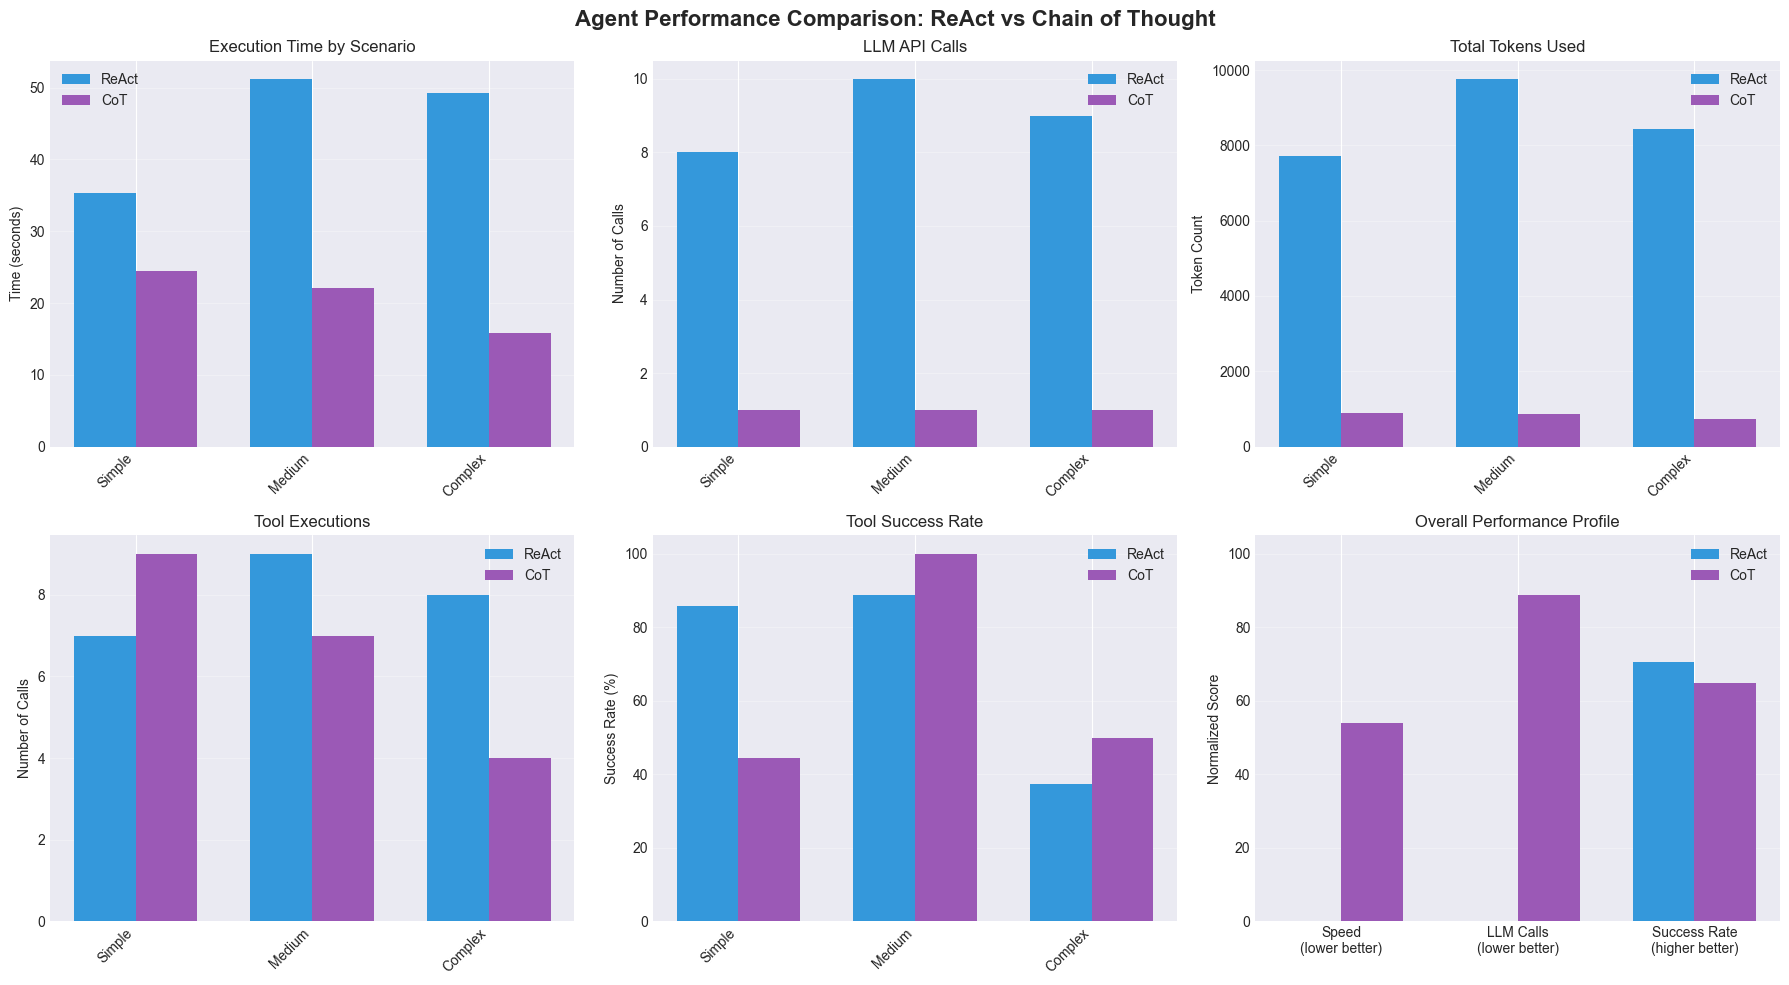

✓ Visualizations generated

In [13]:
# Cell 13: Performance Visualizations
"""
Create comprehensive visualizations
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Agent Performance Comparison: ReAct vs Chain of Thought', fontsize=16, fontweight='bold')

# Prepare data
react_df = df[df["agent_type"] == "ReAct"]
cot_df = df[df["agent_type"] == "CoT"]

scenarios = df["scenario"].unique()
x = np.arange(len(scenarios))
width = 0.35

# 1. Execution Time
ax1 = axes[0, 0]
ax1.bar(x - width/2, react_df.groupby('scenario')['total_time'].mean(), width, label='ReAct', color='#3498db')
ax1.bar(x + width/2, cot_df.groupby('scenario')['total_time'].mean(), width, label='CoT', color='#9b59b6')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time by Scenario')
ax1.set_xticks(x)
ax1.set_xticklabels([s.split('-')[0].strip() for s in scenarios], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. LLM Calls
ax2 = axes[0, 1]
ax2.bar(x - width/2, react_df.groupby('scenario')['llm_calls'].mean(), width, label='ReAct', color='#3498db')
ax2.bar(x + width/2, cot_df.groupby('scenario')['llm_calls'].mean(), width, label='CoT', color='#9b59b6')
ax2.set_ylabel('Number of Calls')
ax2.set_title('LLM API Calls')
ax2.set_xticks(x)
ax2.set_xticklabels([s.split('-')[0].strip() for s in scenarios], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Token Usage
ax3 = axes[0, 2]
ax3.bar(x - width/2, react_df.groupby('scenario')['total_tokens'].mean(), width, label='ReAct', color='#3498db')
ax3.bar(x + width/2, cot_df.groupby('scenario')['total_tokens'].mean(), width, label='CoT', color='#9b59b6')
ax3.set_ylabel('Token Count')
ax3.set_title('Total Tokens Used')
ax3.set_xticks(x)
ax3.set_xticklabels([s.split('-')[0].strip() for s in scenarios], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Tool Calls
ax4 = axes[1, 0]
ax4.bar(x - width/2, react_df.groupby('scenario')['tool_calls'].mean(), width, label='ReAct', color='#3498db')
ax4.bar(x + width/2, cot_df.groupby('scenario')['tool_calls'].mean(), width, label='CoT', color='#9b59b6')
ax4.set_ylabel('Number of Calls')
ax4.set_title('Tool Executions')
ax4.set_xticks(x)
ax4.set_xticklabels([s.split('-')[0].strip() for s in scenarios], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Success Rate
ax5 = axes[1, 1]
ax5.bar(x - width/2, react_df.groupby('scenario')['success_rate'].mean() * 100, width, label='ReAct', color='#3498db')
ax5.bar(x + width/2, cot_df.groupby('scenario')['success_rate'].mean() * 100, width, label='CoT', color='#9b59b6')
ax5.set_ylabel('Success Rate (%)')
ax5.set_title('Tool Success Rate')
ax5.set_xticks(x)
ax5.set_xticklabels([s.split('-')[0].strip() for s in scenarios], rotation=45, ha='right')
ax5.set_ylim([0, 105])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Overall Comparison (Radar Chart Alternative - Bar Chart)
ax6 = axes[1, 2]
categories = ['Speed\n(lower better)', 'LLM Calls\n(lower better)', 'Success Rate\n(higher better)']

# Normalize metrics (0-100 scale, where higher is better)
react_speed = 100 - (react_df['total_time'].mean() / max(react_df['total_time'].mean(), cot_df['total_time'].mean()) * 100)
cot_speed = 100 - (cot_df['total_time'].mean() / max(react_df['total_time'].mean(), cot_df['total_time'].mean()) * 100)

react_llm = 100 - (react_df['llm_calls'].mean() / max(react_df['llm_calls'].mean(), cot_df['llm_calls'].mean()) * 100)
cot_llm = 100 - (cot_df['llm_calls'].mean() / max(react_df['llm_calls'].mean(), cot_df['llm_calls'].mean()) * 100)

react_success = react_df['success_rate'].mean() * 100
cot_success = cot_df['success_rate'].mean() * 100

x_cats = np.arange(len(categories))
ax6.bar(x_cats - width/2, [react_speed, react_llm, react_success], width, label='ReAct', color='#3498db')
ax6.bar(x_cats + width/2, [cot_speed, cot_llm, cot_success], width, label='CoT', color='#9b59b6')
ax6.set_ylabel('Normalized Score')
ax6.set_title('Overall Performance Profile')
ax6.set_xticks(x_cats)
ax6.set_xticklabels(categories)
ax6.set_ylim([0, 105])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

console.print("\n[bold green]✓ Visualizations generated[/bold green]")

In [14]:
# Cell 14: Detailed Analysis & Insights
"""
Generate insights and recommendations
"""

console.print("\n" + "="*70)
console.print("[bold cyan]🔍 DETAILED ANALYSIS & INSIGHTS[/bold cyan]")
console.print("="*70 + "\n")

# Efficiency metrics
react_avg_time = react_df['total_time'].mean()
cot_avg_time = cot_df['total_time'].mean()
time_diff_pct = abs(react_avg_time - cot_avg_time) / max(react_avg_time, cot_avg_time) * 100

react_avg_llm = react_df['llm_calls'].mean()
cot_avg_llm = cot_df['llm_calls'].mean()
llm_diff_pct = abs(react_avg_llm - cot_avg_llm) / max(react_avg_llm, cot_avg_llm) * 100

react_avg_tokens = react_df['total_tokens'].mean()
cot_avg_tokens = cot_df['total_tokens'].mean()
token_diff_pct = abs(react_avg_tokens - cot_avg_tokens) / max(react_avg_tokens, cot_avg_tokens) * 100

console.print("[bold yellow]⚡ Efficiency Analysis:[/bold yellow]\n")

if cot_avg_time < react_avg_time:
    console.print(f"  • CoT is [green]{time_diff_pct:.1f}% faster[/green] than ReAct")
    console.print(f"    ({cot_avg_time:.2f}s vs {react_avg_time:.2f}s average)\n")
else:
    console.print(f"  • ReAct is [green]{time_diff_pct:.1f}% faster[/green] than CoT")
    console.print(f"    ({react_avg_time:.2f}s vs {cot_avg_time:.2f}s average)\n")

if cot_avg_llm < react_avg_llm:
    console.print(f"  • CoT uses [green]{llm_diff_pct:.1f}% fewer LLM calls[/green] than ReAct")
    console.print(f"    ({cot_avg_llm:.1f} vs {react_avg_llm:.1f} calls average)\n")
else:
    console.print(f"  • ReAct uses [green]{llm_diff_pct:.1f}% fewer LLM calls[/green] than CoT")
    console.print(f"    ({react_avg_llm:.1f} vs {cot_avg_llm:.1f} calls average)\n")

if cot_avg_tokens < react_avg_tokens:
    console.print(f"  • CoT uses [green]{token_diff_pct:.1f}% fewer tokens[/green] than ReAct")
    console.print(f"    ({cot_avg_tokens:,.0f} vs {react_avg_tokens:,.0f} tokens average)\n")
else:
    console.print(f"  • ReAct uses [green]{token_diff_pct:.1f}% fewer tokens[/green] than CoT")
    console.print(f"    ({react_avg_tokens:,.0f} vs {cot_avg_tokens:,.0f} tokens average)\n")

# Reliability
console.print("[bold yellow]🎯 Reliability Analysis:[/bold yellow]\n")

react_completion = react_df['task_completed'].mean() * 100
cot_completion = cot_df['task_completed'].mean() * 100
react_success = react_df['success_rate'].mean() * 100
cot_success = cot_df['success_rate'].mean() * 100

console.print(f"  • ReAct: {react_completion:.0f}% task completion, {react_success:.0f}% tool success")
console.print(f"  • CoT: {cot_completion:.0f}% task completion, {cot_success:.0f}% tool success\n")

# Cost estimation
if CONFIG["llm_provider"] != "ollama":
    console.print("[bold yellow]💰 Cost Analysis:[/bold yellow]\n")
    react_cost = react_df['estimated_cost'].sum()
    cot_cost = cot_df['estimated_cost'].sum()
    console.print(f"  • ReAct total cost: ${react_cost:.4f}")
    console.print(f"  • CoT total cost: ${cot_cost:.4f}\n")

# Recommendations
console.print("[bold yellow]💡 Recommendations:[/bold yellow]\n")

console.print("  [bold blue]Use ReAct when:[/bold blue]")
console.print("    • Task requirements are unclear or may change")
console.print("    • You need adaptability and error recovery")
console.print("    • Debugging or exploratory work")
console.print("    • Complex problem-solving required\n")

console.print("  [bold magenta]Use CoT when:[/bold magenta]")
console.print("    • Task is well-defined and deterministic")
console.print("    • Setting up standard project structures")
console.print("    • Cost/speed optimization is priority")
console.print("    • You want predictable execution\n")

console.print("  [bold cyan]Hybrid Approach:[/bold cyan]")
console.print("    • Use CoT for initial setup/planning")
console.print("    • Switch to ReAct if errors occur")
console.print("    • Best of both worlds!\n")

======================================================================

🔍 DETAILED ANALYSIS & INSIGHTS

======================================================================

⚡ Efficiency Analysis:

• CoT is 54.0% faster than ReAct

(20.81s vs 45.28s average)

• CoT uses 88.9% fewer LLM calls than ReAct

(1.0 vs 9.0 calls average)

• CoT uses 90.5% fewer tokens than ReAct

(823 vs 8,644 tokens average)

🎯 Reliability Analysis:

• ReAct: 67% task completion, 71% tool success

• CoT: 100% task completion, 65% tool success

💰 Cost Analysis:

• ReAct total cost: $0.0000

• CoT total cost: $0.0000

💡 Recommendations:

Use ReAct when:

• Task requirements are unclear or may change

• You need adaptability and error recovery

• Debugging or exploratory work

• Complex problem-solving required

Use CoT when:

• Task is well-defined and deterministic

• Setting up standard project structures

• Cost/speed optimization is priority

• You want predictable execution

Hybrid Approach:

• Use CoT for initial setup/planning

• Switch to ReAct if errors occur

• Best of both worlds!

In [15]:
# Cell 15: Export Results
"""
Export results to CSV and JSON for further analysis
"""

output_dir = Path("comparison_results")
output_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export to CSV
csv_path = output_dir / f"agent_comparison_{timestamp}.csv"
df.to_csv(csv_path, index=False)

# Export to JSON
json_path = output_dir / f"agent_comparison_{timestamp}.json"
df.to_json(json_path, orient='records', indent=2)

console.print("\n[bold green]✓ Results exported:[/bold green]")
console.print(f"  • CSV: {csv_path}")
console.print(f"  • JSON: {json_path}\n")

# Summary report
report_path = output_dir / f"summary_report_{timestamp}.txt"
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("AGENT COMPARISON REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: {CONFIG['ollama_model']}\n")
    f.write(f"Scenarios tested: {len(TEST_SCENARIOS)}\n\n")
    
    f.write("AVERAGE METRICS:\n")
    f.write("-" * 70 + "\n")
    f.write(f"ReAct  - Time: {react_avg_time:.2f}s, LLM Calls: {react_avg_llm:.1f}, Tokens: {react_avg_tokens:,.0f}\n")
    f.write(f"CoT    - Time: {cot_avg_time:.2f}s, LLM Calls: {cot_avg_llm:.1f}, Tokens: {cot_avg_tokens:,.0f}\n\n")
    
    f.write("WINNER: ")
    if react_wins > cot_wins:
        f.write("ReAct\n")
    elif cot_wins > react_wins:
        f.write("Chain of Thought\n")
    else:
        f.write("Tie\n")

console.print(f"  • Report: {report_path}\n")
console.print("[bold cyan]🎉 Comparison complete! Check the output files for detailed results.[/bold cyan]")

✓ Results exported:

• CSV: comparison_results/agent_comparison_20251114_163621.csv

• JSON: comparison_results/agent_comparison_20251114_163621.json

• Report: comparison_results/summary_report_20251114_163621.txt

🎉 Comparison complete! Check the output files for detailed results.

# Conclusion

## Key Findings

This notebook provides a comprehensive, data-driven comparison between **ReAct** and **Chain of Thought** agents across multiple dimensions:

### Metrics Measured
- ⏱️ **Execution Time**: Total time to complete tasks
- 🔄 **LLM Calls**: Number of API calls to the language model
- 🔧 **Tool Executions**: Number of tool calls made
- 📊 **Token Usage**: Total input/output tokens
- ✅ **Success Rate**: Percentage of successful tool executions
- 🎯 **Completion Rate**: Whether tasks were fully completed
- 💰 **Cost**: Estimated API costs (when applicable)

### Pattern Comparison

**ReAct Pattern**: Think → Act → Observe → Think → Act...
- Iterative approach
- Adapts based on observations
- Multiple LLM calls

**CoT Pattern**: Plan Everything → Execute All → Report
- Single planning phase
- Batch execution
- One LLM call for planning

### Use Cases

**Choose ReAct for:**
- Unknown or changing requirements
- Complex debugging
- Exploratory tasks
- When adaptability matters more than speed

**Choose CoT for:**
- Well-defined, deterministic tasks
- Standard project setup
- Cost/speed optimization
- Predictable workflows

---

**Next Steps:**
1. Review the exported CSV/JSON files for detailed analysis
2. Try modifying test scenarios for your specific use cases
3. Experiment with hybrid approaches (CoT for planning, ReAct for error recovery)
4. Increase `test_runs_per_scenario` for statistical significance
